# Импорты

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import optuna
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve
from sklearn.neighbors import BallTree

n:\Programming\Learning\MLOPS\3block\firesproject\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Первичный осмотр датасета о пожарах

In [4]:
#Загрузка исходного датасета
ininv = pd.read_csv('thermopoints.csv', sep=";")

#Первичный просмотр и анализ
ininv.head()
ininv.describe()
ininv.info()

print("Дубликаты:", ininv.duplicated().sum())
print(ininv.isnull().sum())

#Удаление дубликатов
ininv = ininv.drop_duplicates().dropna(subset=["dt","lon","lat"])
print("Дубликаты после очистки:", ininv.duplicated().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660254 entries, 0 to 660253
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   dt         660254 non-null  object 
 1   type_name  660254 non-null  object 
 2   type_id    660254 non-null  int64  
 3   lon        660254 non-null  float64
 4   lat        660254 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 25.2+ MB
Дубликаты: 1466
dt           0
type_name    0
type_id      0
lon          0
lat          0
dtype: int64
Дубликаты после очистки: 0


# Расширение временных признаков и уменьшение вариативности координатк в более унифицированную сетку

In [5]:
# Разделение временных признаков
ininv['dt'] = pd.to_datetime(ininv['dt'], dayfirst=True)
ininv['year'] = ininv['dt'].dt.year
ininv['month'] = ininv['dt'].dt.month
ininv['weekday'] = ininv['dt'].dt.weekday
# Схлопывание уникальных геометок на сетку в 0.5 градусов
grid = 0.5
ininv['lon_cell'] = (ininv['lon'] // grid) * grid
ininv['lat_cell'] = (ininv['lat'] // grid) * grid

C:\Users\anatb\AppData\Local\Temp\ipykernel_42676\118883306.py:2: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  ininv['dt'] = pd.to_datetime(ininv['dt'], dayfirst=True)


# Проведение EDA

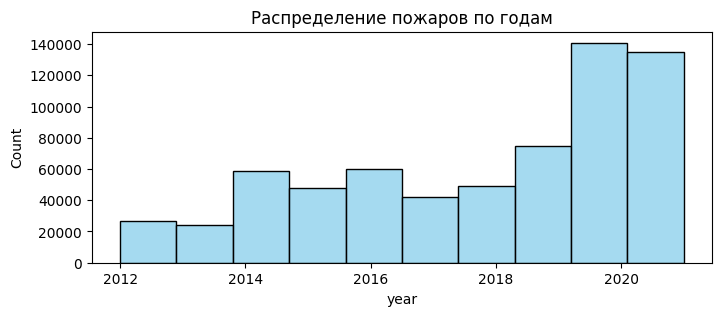

C:\Users\anatb\AppData\Local\Temp\ipykernel_42676\3257064089.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='month', data=ininv, palette='viridis')


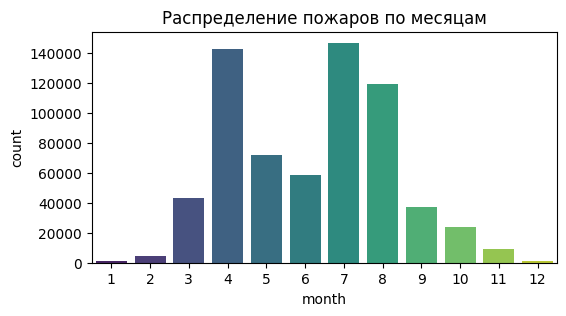

C:\Users\anatb\AppData\Local\Temp\ipykernel_42676\3257064089.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='weekday', data=ininv, palette='magma')


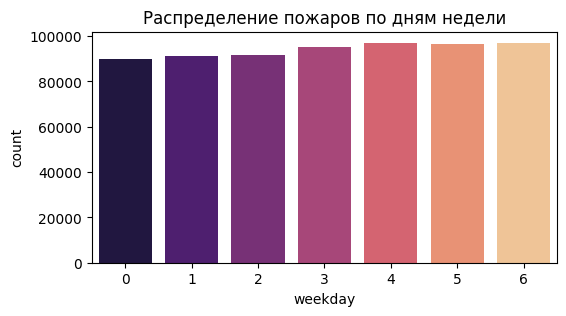

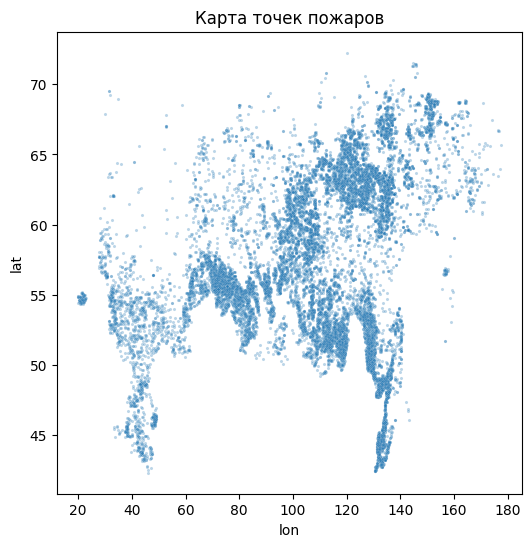

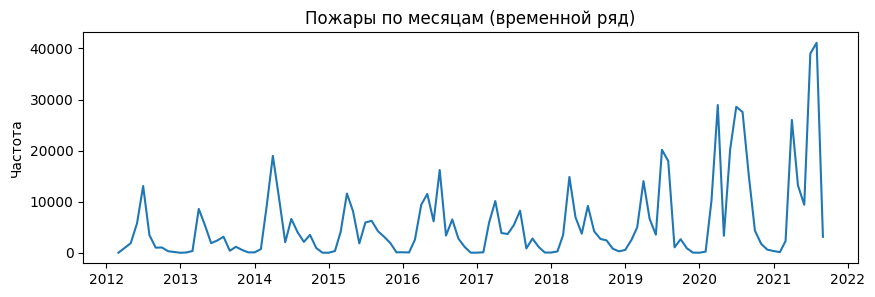

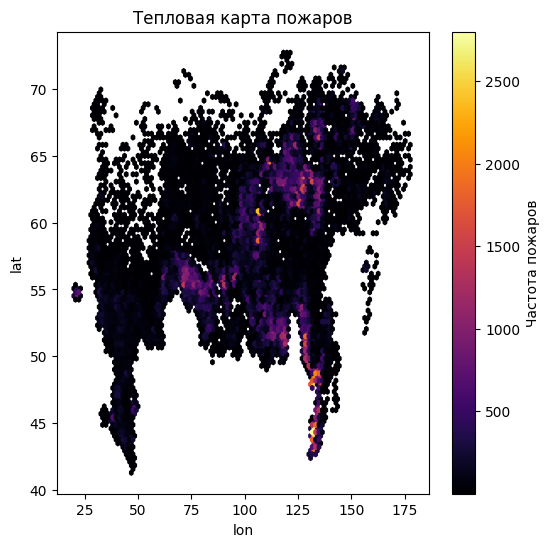

,lon_cell,lat_cell,count
4119,106.5,60.5,2350
5843,132.0,44.0,2162
5795,131.5,44.0,2035
5796,131.5,44.5,1858
4216,108.0,59.5,1589
5794,131.5,43.5,1551
5527,128.0,51.0,1460
4051,105.5,58.5,1430
5798,131.5,47.5,1419
5749,131.0,47.5,1391


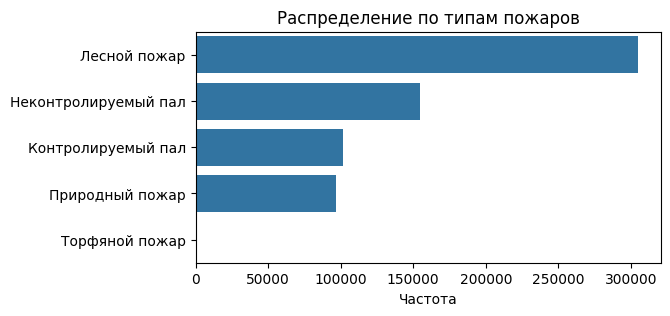

In [6]:
#EDA
# Распределение пожаров по годам
plt.figure(figsize=(8,3))
sns.histplot(ininv['year'], bins=ininv['year'].nunique(), color='skyblue')
plt.title('Распределение пожаров по годам')
plt.show()

# Распределение по месяцам
plt.figure(figsize=(6,3))
sns.countplot(x='month', data=ininv, palette='viridis')
plt.title('Распределение пожаров по месяцам')
plt.show()

# Распределение по дням недели
plt.figure(figsize=(6,3))
sns.countplot(x='weekday', data=ininv, palette='magma')
plt.title('Распределение пожаров по дням недели')
plt.show()

# Карта точек пожаров (выборка)
plt.figure(figsize=(6,6))
sns.scatterplot(x='lon', y='lat', data=ininv.sample(20000, random_state=1), s=5, alpha=0.3)
plt.title('Карта точек пожаров')
plt.show()

# Построить количество пожаров в разрезе «год–месяц» , чтобы увидеть долгосрочный тренд и сезонность
df_r = ininv.groupby([ininv["dt"].dt.to_period("M")]).size().reset_index(name="count")
df_r["dt"] = df_r["dt"].dt.to_timestamp()
plt.figure(figsize=(10,3))
sns.lineplot(data=df_r, x="dt", y="count")
plt.title("Пожары по месяцам (временной ряд)")
plt.xlabel("")
plt.ylabel("Частота")
plt.show()

#  “Тепловая” карта (hexbin)
plt.figure(figsize=(6,6))
plt.hexbin(ininv["lon"], ininv["lat"], gridsize=100, cmap="inferno", mincnt=1)
plt.colorbar(label="Частота пожаров")
plt.title("Тепловая карта пожаров")
plt.xlabel("lon"); plt.ylabel("lat")
plt.show()

# Посчитать число пожаров в каждой ячейке и вывести топ 10:
hot = (
    ininv.groupby(["lon_cell","lat_cell"])
    .size().reset_index(name="count")
    .sort_values("count", ascending=False)
    .head(10)
)
display(hot)

# Разбивка по категориям пожаров
plt.figure(figsize=(6,3))
sns.countplot(y="type_name", data=ininv, order=ininv["type_name"].value_counts().index)
plt.title("Распределение по типам пожаров")
plt.xlabel("Частота"); plt.ylabel("")
plt.show()


# Генерация негативов, т.к. исходный датасет состоит только из положительных критериев

In [ ]:
#Учитывая, что у нас только положительный датасет, генерируем равномерные негативы
#Выборка позитивов
pos = ininv[['lon_cell','lat_cell','dt','year','month','weekday']].copy()
pos['target'] = 1
n_pos = len(pos)

all_dates = pd.date_range(
    start=ininv['dt'].min().normalize(),
    end=ininv['dt'].max().normalize(),
    freq='D'
).to_pydatetime().tolist()

# Считаем частоту каждой ячейки среди позитива
cell_freq = (
    pos.groupby(['lon_cell','lat_cell'])
       .size()
       .reset_index(name='count')
)
cell_freq['prob'] = cell_freq['count'] / cell_freq['count'].sum()

cells   = list(zip(cell_freq['lon_cell'], cell_freq['lat_cell']))
weights = cell_freq['prob'].tolist()

# Генерация негативов
def sample_neg(n):
    rows = []
    for _ in range(n):
        lon, lat = random.choices(cells, weights=weights, k=1)[0]
        dt       = random.choice(all_dates)
        rows.append({
            'lon_cell': lon,
            'lat_cell': lat,
            'dt':        pd.Timestamp(dt),
            'year':      dt.year,
            'month':     dt.month,
            'weekday':   dt.weekday(),
            'target':    0
        })
    return pd.DataFrame(rows)

neg = sample_neg(n_pos)

data_full = pd.concat([pos, neg], ignore_index=True)

# Кодируем координаты в единую колонку(параметр)
data_full['cell_id'] = data_full['lon_cell'].astype(str) + '_' + data_full['lat_cell'].astype(str)
data_full['cell_id_enc'] = LabelEncoder().fit_transform(data_full['cell_id'])


C:\Users\anatb\AppData\Local\Temp\ipykernel_42676\500048280.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


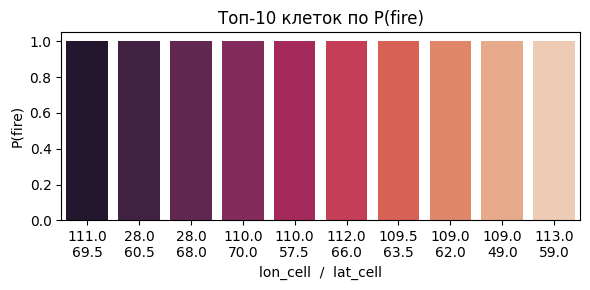

C:\Users\anatb\AppData\Local\Temp\ipykernel_42676\500048280.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='month', y='target', data=grp_m, palette='viridis')


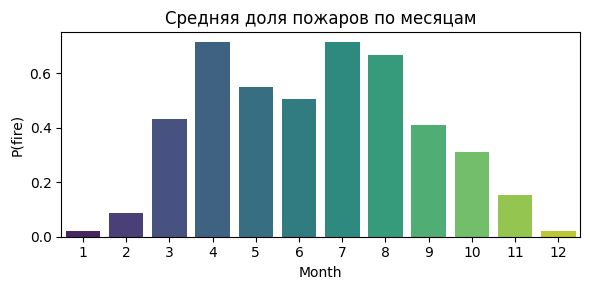

C:\Users\anatb\AppData\Local\Temp\ipykernel_42676\500048280.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='weekday', y='target', data=grp_w, palette='magma')


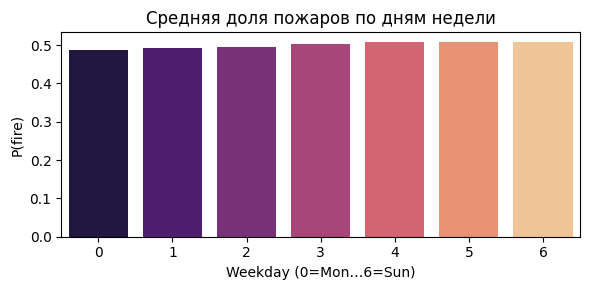

In [8]:
# === Анализ P(fire) по ячейкам ===
agg = (
    data_full.groupby(['lon_cell','lat_cell'])['target']
             .agg(['sum','count'])
             .rename(columns={'sum':'pos','count':'total'})
)
agg['P_fire'] = agg['pos'] / agg['total']
hot = agg.sort_values('P_fire', ascending=False).head(10).reset_index()

plt.figure(figsize=(6,3))
sns.barplot(
    x=hot.index.astype(str),
    y=hot['P_fire'],
    palette='rocket'
)
plt.xticks(range(10), hot['lon_cell'].astype(str)+'\n'+hot['lat_cell'].astype(str))
plt.title('Топ-10 клеток по P(fire)')
plt.ylabel('P(fire)')
plt.xlabel('lon_cell  /  lat_cell')
plt.tight_layout()
plt.show()

# === Анализ P(fire) по месяцам ===
grp_m = data_full.groupby('month')['target'].mean().reset_index()
plt.figure(figsize=(6,3))
sns.barplot(x='month', y='target', data=grp_m, palette='viridis')
plt.title('Средняя доля пожаров по месяцам')
plt.ylabel('P(fire)')
plt.xlabel('Month')
plt.tight_layout()
plt.show()

# === Анализ P(fire) по дням недели ===
grp_w = data_full.groupby('weekday')['target'].mean().reset_index()
plt.figure(figsize=(6,3))
sns.barplot(x='weekday', y='target', data=grp_w, palette='magma')
plt.title('Средняя доля пожаров по дням недели')
plt.ylabel('P(fire)')
plt.xlabel('Weekday (0=Mon…6=Sun)')
plt.tight_layout()
plt.show()

# Сбор бейзлайн модели на урезнной выборке в 100к строк, и метрики

In [ ]:
#Baseline с LGBM
df = data_full.copy()

# сбалансированная выборка 100k
pos_sub = df[df.target==1].sample(50000, random_state=42)
neg_sub = df[df.target==0].sample(50000, random_state=42)
sub = pd.concat([pos_sub, neg_sub], ignore_index=True)

X = sub[['year','month','weekday','cell_id_enc']]
y = sub['target']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

model = lgb.LGBMClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

probs = model.predict_proba(X_val)[:,1]
preds = (probs>0.5).astype(int)

print("ROC AUC:", roc_auc_score(y_val, probs))
print("F1      :", f1_score(y_val, preds))

#Важность фичей
imps = pd.Series(
    model.feature_importances_,
    index=['year','month','weekday','cell_id_enc']
).sort_values(ascending=False)
print("Feature importances:")
print(imps)

# ROC AUC: 0.880401795
# F1      : 0.8041515809799662
# Feature importances:
# cell_id_enc    1438
# year            727
# month           714
# weekday         121


[LightGBM] [Info] Number of positive: 40000, number of negative: 40000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
ROC AUC: 0.880401795
F1      : 0.8041515809799662
Feature importances:
cell_id_enc    1438
year            727
month           714
weekday         121
dtype: int32


# Фиче инжениринг
## Попробуем добавить ближайшие пожары за 7 и 30 дней до пожара в выбранной точке

In [ ]:


# Сразу переиндексируем (чтобы .iterrows() шёл по меньшему df)
df_sub = sub.sort_values('dt').reset_index(drop=True)

# 3. Собираем KD-tree из оригинальных пожаров (ininv как есть)
coords = np.radians(ininv[['lat','lon']].values)
tree = BallTree(coords, metric='haversine')
radius = 5/6371.0

df_sub['fires_last_7d']  = 0
df_sub['fires_last_30d'] = 0

for idx, row in df_sub.iterrows():
    t0 = row['dt']
    mask7  = (ininv['dt'] < t0) & (ininv['dt'] >= t0 - pd.Timedelta(days=7))
    pts7   = np.radians(ininv.loc[mask7, ['lat','lon']].values)
    df_sub.at[idx, 'fires_last_7d']  = tree.query_radius(
        [[np.radians(row['lat_cell']), np.radians(row['lon_cell'])]],
        r=radius, count_only=True
    )[0]
    df_sub.at[idx, 'fires_last_30d'] = tree.query_radius(
        [[np.radians(row['lat_cell']), np.radians(row['lon_cell'])]],
        r=radius, count_only=True
    )[0]




## Посмотрим распределения двух новых фич

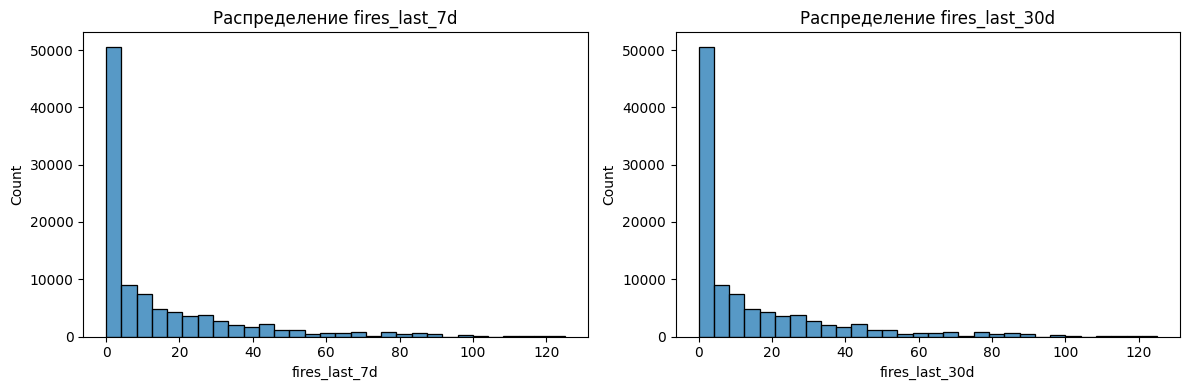

C:\Users\anatb\AppData\Local\Temp\ipykernel_42676\1442692787.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp7 = df_sub.groupby('bin7')['target'].mean().reset_index()
C:\Users\anatb\AppData\Local\Temp\ipykernel_42676\1442692787.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bin7', y='target', data=grp7, palette='coolwarm')


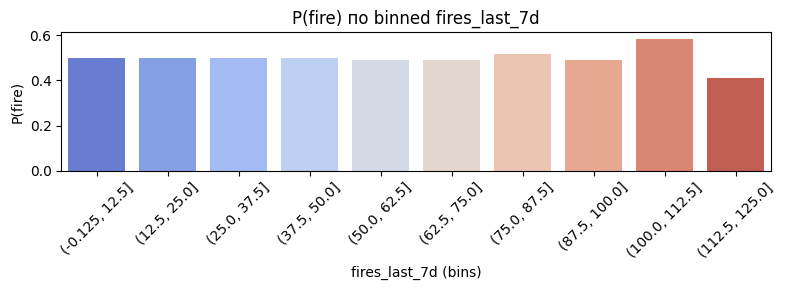

C:\Users\anatb\AppData\Local\Temp\ipykernel_42676\1442692787.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp30 = df_sub.groupby('bin30')['target'].mean().reset_index()
C:\Users\anatb\AppData\Local\Temp\ipykernel_42676\1442692787.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bin30', y='target', data=grp30, palette='viridis')


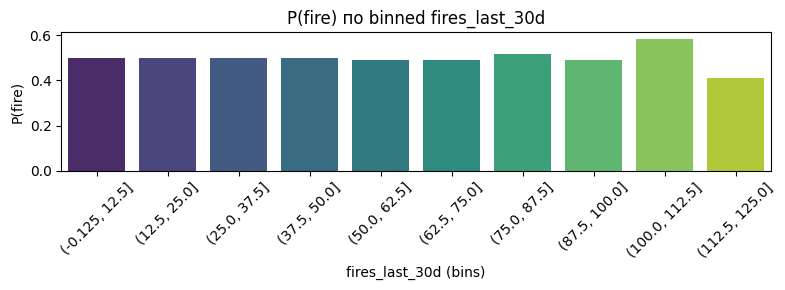

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.histplot(df_sub['fires_last_7d'], bins=30, ax=axes[0])
axes[0].set_title('Распределение fires_last_7d')
sns.histplot(df_sub['fires_last_30d'], bins=30, ax=axes[1])
axes[1].set_title('Распределение fires_last_30d')
plt.tight_layout()
plt.show()

df_sub['bin7'] = pd.cut(df_sub['fires_last_7d'], bins=10)
grp7 = df_sub.groupby('bin7')['target'].mean().reset_index()
plt.figure(figsize=(8,3))
sns.barplot(x='bin7', y='target', data=grp7, palette='coolwarm')
plt.xticks(rotation=45)
plt.title('P(fire) по binned fires_last_7d')
plt.ylabel('P(fire)')
plt.xlabel('fires_last_7d (bins)')
plt.tight_layout()
plt.show()

df_sub['bin30'] = pd.cut(df_sub['fires_last_30d'], bins=10)
grp30 = df_sub.groupby('bin30')['target'].mean().reset_index()
plt.figure(figsize=(8,3))
sns.barplot(x='bin30', y='target', data=grp30, palette='viridis')
plt.xticks(rotation=45)
plt.title('P(fire) по binned fires_last_30d')
plt.ylabel('P(fire)')
plt.xlabel('fires_last_30d (bins)')
plt.tight_layout()
plt.show()


## Попробуем обучить LGBM с новыми фичами с помощью оптуна

[I 2025-07-13 23:38:09,976] A new study created in memory with name: no-name-7a13dcc5-821a-4e55-ae64-01111740e1da
  0%|          | 0/50 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[317]	valid_0's auc: 0.861036
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[317]	valid_0's auc: 0.860496
Training until validation scores don't improve for 50 rounds


Best trial: 0. Best value: 0.857982:   2%|▏         | 1/50 [00:04<03:25,  4.19s/it]

Did not meet early stopping. Best iteration is:
[317]	valid_0's auc: 0.852415
[I 2025-07-13 23:38:14,169] Trial 0 finished with value: 0.8579820694727083 and parameters: {'n_estimators': 317, 'learning_rate': 0.014114570724116794, 'num_leaves': 139, 'max_depth': 6, 'min_data_in_leaf': 95, 'feature_fraction': 0.9886005774187733, 'bagging_fraction': 0.9054695959225494, 'bagging_freq': 10, 'lambda_l1': 2.6628287501479624e-08, 'lambda_l2': 3.130627636743769e-07}. Best is trial 0 with value: 0.8579820694727083.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[486]	valid_0's auc: 0.906083
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[540]	valid_0's auc: 0.906912
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[574]	valid_0's auc: 0.904182


Best trial: 1. Best value: 0.905725:   4%|▍         | 2/50 [00:12<05:24,  6.76s/it]

[I 2025-07-13 23:38:22,731] Trial 1 finished with value: 0.9057254278193011 and parameters: {'n_estimators': 651, 'learning_rate': 0.13487487242064802, 'num_leaves': 68, 'max_depth': 9, 'min_data_in_leaf': 44, 'feature_fraction': 0.8733295071272005, 'bagging_fraction': 0.5051770434970275, 'bagging_freq': 3, 'lambda_l1': 0.3585795020751726, 'lambda_l2': 2.827341769425778e-07}. Best is trial 1 with value: 0.9057254278193011.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[212]	valid_0's auc: 0.854079
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[212]	valid_0's auc: 0.855492
Training until validation scores don't improve for 50 rounds


Best trial: 1. Best value: 0.905725:   6%|▌         | 3/50 [00:15<03:59,  5.10s/it]

Did not meet early stopping. Best iteration is:
[212]	valid_0's auc: 0.848741
[I 2025-07-13 23:38:25,844] Trial 2 finished with value: 0.8527707167747064 and parameters: {'n_estimators': 212, 'learning_rate': 0.008537752333984, 'num_leaves': 95, 'max_depth': 7, 'min_data_in_leaf': 61, 'feature_fraction': 0.9155462889093484, 'bagging_fraction': 0.9205034404938892, 'bagging_freq': 6, 'lambda_l1': 7.480970238724778e-07, 'lambda_l2': 4.41980888349625e-08}. Best is trial 1 with value: 0.9057254278193011.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[598]	valid_0's auc: 0.842283
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[598]	valid_0's auc: 0.840057
Training until validation scores don't improve for 50 rounds


Best trial: 1. Best value: 0.905725:   8%|▊         | 4/50 [00:19<03:36,  4.70s/it]

Did not meet early stopping. Best iteration is:
[598]	valid_0's auc: 0.834319
[I 2025-07-13 23:38:29,932] Trial 3 finished with value: 0.8388861728027489 and parameters: {'n_estimators': 598, 'learning_rate': 0.023625812508427536, 'num_leaves': 25, 'max_depth': 3, 'min_data_in_leaf': 53, 'feature_fraction': 0.8372368663190365, 'bagging_fraction': 0.6418613471023706, 'bagging_freq': 9, 'lambda_l1': 0.006334330491910115, 'lambda_l2': 0.05903797468881878}. Best is trial 1 with value: 0.9057254278193011.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[207]	valid_0's auc: 0.909519
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[212]	valid_0's auc: 0.909771
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[212]	valid_0's auc: 0.906217


Best trial: 4. Best value: 0.908502:  10%|█         | 5/50 [00:25<03:38,  4.86s/it]

[I 2025-07-13 23:38:35,070] Trial 4 finished with value: 0.9085023124358332 and parameters: {'n_estimators': 212, 'learning_rate': 0.06242557930058252, 'num_leaves': 166, 'max_depth': 15, 'min_data_in_leaf': 75, 'feature_fraction': 0.9890507269178203, 'bagging_fraction': 0.8651806947118309, 'bagging_freq': 3, 'lambda_l1': 3.044154301108216e-08, 'lambda_l2': 2.390553316176479e-07}. Best is trial 4 with value: 0.9085023124358332.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[36]	valid_0's auc: 0.883451
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	valid_0's auc: 0.885367
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[292]	valid_0's auc: 0.891584


Best trial: 4. Best value: 0.908502:  12%|█▏        | 6/50 [00:29<03:21,  4.59s/it]

[I 2025-07-13 23:38:39,129] Trial 5 finished with value: 0.8868008299556672 and parameters: {'n_estimators': 292, 'learning_rate': 0.010721227631167307, 'num_leaves': 245, 'max_depth': 12, 'min_data_in_leaf': 16, 'feature_fraction': 0.6008945218689028, 'bagging_fraction': 0.5706605151541154, 'bagging_freq': 4, 'lambda_l1': 0.15569677880356625, 'lambda_l2': 0.006323651084912058}. Best is trial 4 with value: 0.9085023124358332.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[609]	valid_0's auc: 0.884792
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[608]	valid_0's auc: 0.886766
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[609]	valid_0's auc: 0.879452


Best trial: 4. Best value: 0.908502:  14%|█▍        | 7/50 [00:36<03:55,  5.48s/it]

[I 2025-07-13 23:38:46,449] Trial 6 finished with value: 0.8836697215080377 and parameters: {'n_estimators': 609, 'learning_rate': 0.024728876621054868, 'num_leaves': 32, 'max_depth': 9, 'min_data_in_leaf': 29, 'feature_fraction': 0.6626246420238197, 'bagging_fraction': 0.7358349371191686, 'bagging_freq': 9, 'lambda_l1': 0.0002642088998885585, 'lambda_l2': 0.0028896617175712997}. Best is trial 4 with value: 0.9085023124358332.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[788]	valid_0's auc: 0.91486
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[790]	valid_0's auc: 0.915224
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[788]	valid_0's auc: 0.911403


Best trial: 7. Best value: 0.913829:  16%|█▌        | 8/50 [00:53<06:20,  9.07s/it]

[I 2025-07-13 23:39:03,195] Trial 7 finished with value: 0.9138290173440614 and parameters: {'n_estimators': 790, 'learning_rate': 0.03877695762055584, 'num_leaves': 168, 'max_depth': 12, 'min_data_in_leaf': 14, 'feature_fraction': 0.6916174166364695, 'bagging_fraction': 0.9786649307351163, 'bagging_freq': 7, 'lambda_l1': 2.401828546686799e-05, 'lambda_l2': 0.0019579544048651918}. Best is trial 7 with value: 0.9138290173440614.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[252]	valid_0's auc: 0.912372
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[399]	valid_0's auc: 0.914784
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[371]	valid_0's auc: 0.91291


Best trial: 7. Best value: 0.913829:  18%|█▊        | 9/50 [01:01<05:55,  8.66s/it]

[I 2025-07-13 23:39:10,976] Trial 8 finished with value: 0.9133553822356291 and parameters: {'n_estimators': 912, 'learning_rate': 0.1433582776142663, 'num_leaves': 216, 'max_depth': 9, 'min_data_in_leaf': 35, 'feature_fraction': 0.9840321171971241, 'bagging_fraction': 0.952692273779703, 'bagging_freq': 6, 'lambda_l1': 0.0008562565600410199, 'lambda_l2': 2.426197333233647e-06}. Best is trial 7 with value: 0.9138290173440614.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[366]	valid_0's auc: 0.905303
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[324]	valid_0's auc: 0.907558
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[315]	valid_0's auc: 0.903979


Best trial: 7. Best value: 0.913829:  20%|██        | 10/50 [01:07<05:18,  7.97s/it]

[I 2025-07-13 23:39:17,389] Trial 9 finished with value: 0.9056133875698026 and parameters: {'n_estimators': 453, 'learning_rate': 0.18646911072772027, 'num_leaves': 82, 'max_depth': 15, 'min_data_in_leaf': 46, 'feature_fraction': 0.8300796938020938, 'bagging_fraction': 0.5050749326082278, 'bagging_freq': 2, 'lambda_l1': 0.9675228733310458, 'lambda_l2': 2.052951621308238e-05}. Best is trial 7 with value: 0.9138290173440614.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[666]	valid_0's auc: 0.908191
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[553]	valid_0's auc: 0.908888
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[891]	valid_0's auc: 0.907378


Best trial: 7. Best value: 0.913829:  22%|██▏       | 11/50 [01:24<07:01, 10.81s/it]

[I 2025-07-13 23:39:34,640] Trial 10 finished with value: 0.9081523261860532 and parameters: {'n_estimators': 900, 'learning_rate': 0.05381181948067099, 'num_leaves': 181, 'max_depth': 12, 'min_data_in_leaf': 11, 'feature_fraction': 0.5321422544629415, 'bagging_fraction': 0.7987638656764909, 'bagging_freq': 7, 'lambda_l1': 6.258048616140961e-06, 'lambda_l2': 4.4579950379287}. Best is trial 7 with value: 0.9138290173440614.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[480]	valid_0's auc: 0.914602
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[496]	valid_0's auc: 0.915555
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[482]	valid_0's auc: 0.912655


Best trial: 11. Best value: 0.914271:  24%|██▍       | 12/50 [01:37<07:13, 11.40s/it]

[I 2025-07-13 23:39:47,385] Trial 11 finished with value: 0.9142706121301835 and parameters: {'n_estimators': 997, 'learning_rate': 0.08299639107851958, 'num_leaves': 222, 'max_depth': 12, 'min_data_in_leaf': 29, 'feature_fraction': 0.6923086143783339, 'bagging_fraction': 0.9931616218236163, 'bagging_freq': 7, 'lambda_l1': 0.00011613459688608922, 'lambda_l2': 3.672703634614033e-05}. Best is trial 11 with value: 0.9142706121301835.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[716]	valid_0's auc: 0.915224
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[672]	valid_0's auc: 0.915493
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[706]	valid_0's auc: 0.91289


Best trial: 12. Best value: 0.914536:  26%|██▌       | 13/50 [01:55<08:21, 13.56s/it]

[I 2025-07-13 23:40:05,911] Trial 12 finished with value: 0.9145356243974972 and parameters: {'n_estimators': 788, 'learning_rate': 0.06307520403510271, 'num_leaves': 202, 'max_depth': 12, 'min_data_in_leaf': 22, 'feature_fraction': 0.7237767333685998, 'bagging_fraction': 0.9896879071570884, 'bagging_freq': 8, 'lambda_l1': 2.4091327018824038e-05, 'lambda_l2': 5.413599115397665e-05}. Best is trial 12 with value: 0.9145356243974972.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[404]	valid_0's auc: 0.915495
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[460]	valid_0's auc: 0.916638
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[470]	valid_0's auc: 0.914652


Best trial: 13. Best value: 0.915595:  28%|██▊       | 14/50 [02:08<07:54, 13.17s/it]

[I 2025-07-13 23:40:18,199] Trial 13 finished with value: 0.9155951093589928 and parameters: {'n_estimators': 963, 'learning_rate': 0.08682107076519965, 'num_leaves': 252, 'max_depth': 13, 'min_data_in_leaf': 29, 'feature_fraction': 0.7587472106585493, 'bagging_fraction': 0.9970347203388613, 'bagging_freq': 8, 'lambda_l1': 0.007346932625757305, 'lambda_l2': 0.00011377603143950657}. Best is trial 13 with value: 0.9155951093589928.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[757]	valid_0's auc: 0.905088
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[757]	valid_0's auc: 0.905844
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[757]	valid_0's auc: 0.901436


Best trial: 13. Best value: 0.915595:  30%|███       | 15/50 [02:31<09:26, 16.18s/it]

[I 2025-07-13 23:40:41,333] Trial 14 finished with value: 0.9041225558567335 and parameters: {'n_estimators': 757, 'learning_rate': 0.005137790994435529, 'num_leaves': 255, 'max_depth': 14, 'min_data_in_leaf': 27, 'feature_fraction': 0.758622230829121, 'bagging_fraction': 0.8388726129919095, 'bagging_freq': 8, 'lambda_l1': 0.02403807651708018, 'lambda_l2': 0.00010451610150331778}. Best is trial 13 with value: 0.9155951093589928.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[300]	valid_0's auc: 0.910488
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[232]	valid_0's auc: 0.909427
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[356]	valid_0's auc: 0.908899


Best trial: 13. Best value: 0.915595:  32%|███▏      | 16/50 [02:39<07:48, 13.77s/it]

[I 2025-07-13 23:40:49,524] Trial 15 finished with value: 0.9096045066942319 and parameters: {'n_estimators': 775, 'learning_rate': 0.1015756841452976, 'num_leaves': 210, 'max_depth': 13, 'min_data_in_leaf': 69, 'feature_fraction': 0.7574716767159896, 'bagging_fraction': 0.7282943325637776, 'bagging_freq': 10, 'lambda_l1': 0.007640220428644059, 'lambda_l2': 0.20983821402126246}. Best is trial 13 with value: 0.9155951093589928.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[984]	valid_0's auc: 0.908563
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[984]	valid_0's auc: 0.910075
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[984]	valid_0's auc: 0.906096


Best trial: 13. Best value: 0.915595:  34%|███▍      | 17/50 [03:03<09:15, 16.83s/it]

[I 2025-07-13 23:41:13,465] Trial 16 finished with value: 0.908244544203692 and parameters: {'n_estimators': 985, 'learning_rate': 0.040491620361771556, 'num_leaves': 190, 'max_depth': 11, 'min_data_in_leaf': 42, 'feature_fraction': 0.61922926205813, 'bagging_fraction': 0.886560442843026, 'bagging_freq': 5, 'lambda_l1': 5.866657094893309, 'lambda_l2': 5.31725440991102e-06}. Best is trial 13 with value: 0.9155951093589928.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[419]	valid_0's auc: 0.912515
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[646]	valid_0's auc: 0.914655
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[657]	valid_0's auc: 0.911804


Best trial: 13. Best value: 0.915595:  36%|███▌      | 18/50 [03:14<08:05, 15.18s/it]

[I 2025-07-13 23:41:24,812] Trial 17 finished with value: 0.9129914588961164 and parameters: {'n_estimators': 857, 'learning_rate': 0.07073782777097941, 'num_leaves': 135, 'max_depth': 10, 'min_data_in_leaf': 22, 'feature_fraction': 0.8043496816671257, 'bagging_fraction': 0.7943783993099873, 'bagging_freq': 8, 'lambda_l1': 2.2532747972741626e-06, 'lambda_l2': 0.0003908092752863022}. Best is trial 13 with value: 0.9155951093589928.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[229]	valid_0's auc: 0.909969
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[261]	valid_0's auc: 0.911116
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[254]	valid_0's auc: 0.906607


Best trial: 13. Best value: 0.915595:  38%|███▊      | 19/50 [03:23<06:51, 13.26s/it]

[I 2025-07-13 23:41:33,590] Trial 18 finished with value: 0.9092305679967033 and parameters: {'n_estimators': 507, 'learning_rate': 0.11114049717051795, 'num_leaves': 236, 'max_depth': 14, 'min_data_in_leaf': 38, 'feature_fraction': 0.7325787082683474, 'bagging_fraction': 0.6790699577597006, 'bagging_freq': 8, 'lambda_l1': 3.789958861172516e-07, 'lambda_l2': 0.00023311095473697142}. Best is trial 13 with value: 0.9155951093589928.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[666]	valid_0's auc: 0.892475
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[666]	valid_0's auc: 0.892844
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[666]	valid_0's auc: 0.889498


Best trial: 13. Best value: 0.915595:  40%|████      | 20/50 [03:43<07:39, 15.33s/it]

[I 2025-07-13 23:41:53,743] Trial 19 finished with value: 0.8916057135617251 and parameters: {'n_estimators': 666, 'learning_rate': 0.048412830026834476, 'num_leaves': 135, 'max_depth': 7, 'min_data_in_leaf': 84, 'feature_fraction': 0.5007846166944189, 'bagging_fraction': 0.9554497891208248, 'bagging_freq': 1, 'lambda_l1': 0.0009736844873648797, 'lambda_l2': 0.0355010154240495}. Best is trial 13 with value: 0.9155951093589928.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[701]	valid_0's auc: 0.906701
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[701]	valid_0's auc: 0.908023
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[701]	valid_0's auc: 0.903481


Best trial: 13. Best value: 0.915595:  42%|████▏     | 21/50 [04:40<13:24, 27.75s/it]

[I 2025-07-13 23:42:50,439] Trial 20 finished with value: 0.9060685803157927 and parameters: {'n_estimators': 702, 'learning_rate': 0.027802803448080962, 'num_leaves': 191, 'max_depth': 10, 'min_data_in_leaf': 53, 'feature_fraction': 0.5946914517341919, 'bagging_fraction': 0.8043428904438398, 'bagging_freq': 5, 'lambda_l1': 4.3644280182491944e-05, 'lambda_l2': 3.6679727282036543e-06}. Best is trial 13 with value: 0.9155951093589928.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[470]	valid_0's auc: 0.915261
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[488]	valid_0's auc: 0.916491
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[576]	valid_0's auc: 0.912612


Best trial: 13. Best value: 0.915595:  44%|████▍     | 22/50 [04:53<10:50, 23.24s/it]

[I 2025-07-13 23:43:03,174] Trial 21 finished with value: 0.9147880229126524 and parameters: {'n_estimators': 965, 'learning_rate': 0.07549708483226093, 'num_leaves': 225, 'max_depth': 13, 'min_data_in_leaf': 23, 'feature_fraction': 0.7061797584925257, 'bagging_fraction': 0.9870290208340998, 'bagging_freq': 7, 'lambda_l1': 9.767274399692621e-05, 'lambda_l2': 4.348637034810483e-05}. Best is trial 13 with value: 0.9155951093589928.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[356]	valid_0's auc: 0.915596
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[403]	valid_0's auc: 0.916765
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[371]	valid_0's auc: 0.913402


Best trial: 13. Best value: 0.915595:  46%|████▌     | 23/50 [05:02<08:35, 19.08s/it]

[I 2025-07-13 23:43:12,547] Trial 22 finished with value: 0.9152541937385236 and parameters: {'n_estimators': 878, 'learning_rate': 0.08378495691553282, 'num_leaves': 219, 'max_depth': 14, 'min_data_in_leaf': 25, 'feature_fraction': 0.7836853285280257, 'bagging_fraction': 0.9989810172137183, 'bagging_freq': 9, 'lambda_l1': 1.1142933007009824e-05, 'lambda_l2': 1.2804412583402211e-05}. Best is trial 13 with value: 0.9155951093589928.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[178]	valid_0's auc: 0.913234
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[212]	valid_0's auc: 0.914729
Training until validation scores don't improve for 50 rounds


Best trial: 13. Best value: 0.915595:  48%|████▊     | 24/50 [05:07<06:27, 14.90s/it]

Early stopping, best iteration is:
[143]	valid_0's auc: 0.911545
[I 2025-07-13 23:43:17,689] Trial 23 finished with value: 0.9131696156731822 and parameters: {'n_estimators': 922, 'learning_rate': 0.19609128906739398, 'num_leaves': 235, 'max_depth': 14, 'min_data_in_leaf': 20, 'feature_fraction': 0.7895081135149709, 'bagging_fraction': 0.9343147740988479, 'bagging_freq': 9, 'lambda_l1': 0.001133996977199961, 'lambda_l2': 0.0005469603626638013}. Best is trial 13 with value: 0.9155951093589928.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[317]	valid_0's auc: 0.915071
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[359]	valid_0's auc: 0.916008
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[503]	valid_0's auc: 0.913121


Best trial: 13. Best value: 0.915595:  50%|█████     | 25/50 [05:18<05:38, 13.55s/it]

[I 2025-07-13 23:43:28,099] Trial 24 finished with value: 0.9147333830064667 and parameters: {'n_estimators': 863, 'learning_rate': 0.10227298838743579, 'num_leaves': 231, 'max_depth': 13, 'min_data_in_leaf': 35, 'feature_fraction': 0.8875225318572377, 'bagging_fraction': 0.9993362434513662, 'bagging_freq': 10, 'lambda_l1': 0.03384749938311765, 'lambda_l2': 1.2214509677244587e-05}. Best is trial 13 with value: 0.9155951093589928.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[349]	valid_0's auc: 0.914078
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[350]	valid_0's auc: 0.914587
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[424]	valid_0's auc: 0.912264


Best trial: 13. Best value: 0.915595:  52%|█████▏    | 26/50 [05:28<05:05, 12.72s/it]

[I 2025-07-13 23:43:38,874] Trial 25 finished with value: 0.9136430418701224 and parameters: {'n_estimators': 998, 'learning_rate': 0.07682632758244015, 'num_leaves': 250, 'max_depth': 15, 'min_data_in_leaf': 28, 'feature_fraction': 0.6523507190311041, 'bagging_fraction': 0.8580190756060905, 'bagging_freq': 7, 'lambda_l1': 5.971187125727307e-06, 'lambda_l2': 1.0540388870848644e-06}. Best is trial 13 with value: 0.9155951093589928.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[322]	valid_0's auc: 0.915086
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[350]	valid_0's auc: 0.916111
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[420]	valid_0's auc: 0.912733


Best trial: 13. Best value: 0.915595:  54%|█████▍    | 27/50 [05:35<04:13, 11.03s/it]

[I 2025-07-13 23:43:45,966] Trial 26 finished with value: 0.9146432549143985 and parameters: {'n_estimators': 842, 'learning_rate': 0.13932385707911416, 'num_leaves': 158, 'max_depth': 13, 'min_data_in_leaf': 10, 'feature_fraction': 0.7860613740829789, 'bagging_fraction': 0.9436378404799979, 'bagging_freq': 9, 'lambda_l1': 2.650618813988065e-07, 'lambda_l2': 5.172872905048501e-08}. Best is trial 13 with value: 0.9155951093589928.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[932]	valid_0's auc: 0.914419
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[937]	valid_0's auc: 0.915956
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[938]	valid_0's auc: 0.912155


Best trial: 13. Best value: 0.915595:  56%|█████▌    | 28/50 [05:56<05:05, 13.87s/it]

[I 2025-07-13 23:44:06,465] Trial 27 finished with value: 0.9141766401230985 and parameters: {'n_estimators': 940, 'learning_rate': 0.03649910969710917, 'num_leaves': 210, 'max_depth': 11, 'min_data_in_leaf': 20, 'feature_fraction': 0.7205142341444251, 'bagging_fraction': 0.8964212958793228, 'bagging_freq': 6, 'lambda_l1': 0.00010419715367289738, 'lambda_l2': 0.0006062689240752157}. Best is trial 13 with value: 0.9155951093589928.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[735]	valid_0's auc: 0.905405
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[735]	valid_0's auc: 0.906953
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[735]	valid_0's auc: 0.902358


Best trial: 13. Best value: 0.915595:  58%|█████▊    | 29/50 [06:09<04:46, 13.65s/it]

[I 2025-07-13 23:44:19,595] Trial 28 finished with value: 0.9049052129736208 and parameters: {'n_estimators': 735, 'learning_rate': 0.0182936818433566, 'num_leaves': 113, 'max_depth': 14, 'min_data_in_leaf': 60, 'feature_fraction': 0.8397170248317082, 'bagging_fraction': 0.9605954067657752, 'bagging_freq': 8, 'lambda_l1': 0.0011936440152467327, 'lambda_l2': 8.134887354736673e-05}. Best is trial 13 with value: 0.9155951093589928.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[654]	valid_0's auc: 0.912536
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[609]	valid_0's auc: 0.912894
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[785]	valid_0's auc: 0.910693


Best trial: 13. Best value: 0.915595:  60%|██████    | 30/50 [06:23<04:33, 13.70s/it]

[I 2025-07-13 23:44:33,412] Trial 29 finished with value: 0.9120409266715117 and parameters: {'n_estimators': 837, 'learning_rate': 0.09038635986003783, 'num_leaves': 151, 'max_depth': 11, 'min_data_in_leaf': 95, 'feature_fraction': 0.9270472157332564, 'bagging_fraction': 0.9141498743434854, 'bagging_freq': 10, 'lambda_l1': 0.0036004657675526167, 'lambda_l2': 6.808524222658575e-07}. Best is trial 13 with value: 0.9155951093589928.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[945]	valid_0's auc: 0.863758
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[945]	valid_0's auc: 0.863402
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[945]	valid_0's auc: 0.857683


Best trial: 13. Best value: 0.915595:  62%|██████▏   | 31/50 [06:31<03:45, 11.88s/it]

[I 2025-07-13 23:44:41,061] Trial 30 finished with value: 0.8616141720766749 and parameters: {'n_estimators': 945, 'learning_rate': 0.05141730089960852, 'num_leaves': 255, 'max_depth': 3, 'min_data_in_leaf': 36, 'feature_fraction': 0.6863844115736212, 'bagging_fraction': 0.8938642252378408, 'bagging_freq': 9, 'lambda_l1': 5.602805774600904e-08, 'lambda_l2': 1.3569864946260779e-05}. Best is trial 13 with value: 0.9155951093589928.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[323]	valid_0's auc: 0.915598
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[370]	valid_0's auc: 0.916025
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[345]	valid_0's auc: 0.912921


Best trial: 13. Best value: 0.915595:  64%|██████▍   | 32/50 [06:40<03:23, 11.28s/it]

[I 2025-07-13 23:44:50,938] Trial 31 finished with value: 0.9148481349613685 and parameters: {'n_estimators': 870, 'learning_rate': 0.10780525753652673, 'num_leaves': 227, 'max_depth': 13, 'min_data_in_leaf': 31, 'feature_fraction': 0.8755172269787321, 'bagging_fraction': 0.9973341105207415, 'bagging_freq': 10, 'lambda_l1': 0.06244071396732394, 'lambda_l2': 1.2799122643874678e-05}. Best is trial 13 with value: 0.9155951093589928.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[355]	valid_0's auc: 0.913934
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[295]	valid_0's auc: 0.915048
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[336]	valid_0's auc: 0.912915


Best trial: 13. Best value: 0.915595:  66%|██████▌   | 33/50 [06:50<03:01, 10.69s/it]

[I 2025-07-13 23:45:00,255] Trial 32 finished with value: 0.9139656460029815 and parameters: {'n_estimators': 407, 'learning_rate': 0.12261230268641689, 'num_leaves': 225, 'max_depth': 13, 'min_data_in_leaf': 48, 'feature_fraction': 0.8764909223094736, 'bagging_fraction': 0.9687801870420746, 'bagging_freq': 10, 'lambda_l1': 0.11036596201832372, 'lambda_l2': 8.156579721417838e-06}. Best is trial 13 with value: 0.9155951093589928.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[367]	valid_0's auc: 0.915658
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[296]	valid_0's auc: 0.915829
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[337]	valid_0's auc: 0.913194


Best trial: 13. Best value: 0.915595:  68%|██████▊   | 34/50 [06:59<02:43, 10.21s/it]

[I 2025-07-13 23:45:09,335] Trial 33 finished with value: 0.9148933890722107 and parameters: {'n_estimators': 881, 'learning_rate': 0.08742587816745588, 'num_leaves': 200, 'max_depth': 14, 'min_data_in_leaf': 31, 'feature_fraction': 0.9331855785039831, 'bagging_fraction': 0.9293702119336601, 'bagging_freq': 9, 'lambda_l1': 0.03084401280196631, 'lambda_l2': 8.319780317953837e-07}. Best is trial 13 with value: 0.9155951093589928.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[253]	valid_0's auc: 0.914973
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[323]	valid_0's auc: 0.915546
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[349]	valid_0's auc: 0.913339


Best trial: 13. Best value: 0.915595:  70%|███████   | 35/50 [07:08<02:27,  9.81s/it]

[I 2025-07-13 23:45:18,221] Trial 34 finished with value: 0.9146193400828698 and parameters: {'n_estimators': 886, 'learning_rate': 0.1323981446671164, 'num_leaves': 198, 'max_depth': 15, 'min_data_in_leaf': 32, 'feature_fraction': 0.92739449100918, 'bagging_fraction': 0.9223479802237178, 'bagging_freq': 10, 'lambda_l1': 1.4431884537321655, 'lambda_l2': 1.095329428227886e-07}. Best is trial 13 with value: 0.9155951093589928.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[224]	valid_0's auc: 0.913284
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[216]	valid_0's auc: 0.914067
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[284]	valid_0's auc: 0.911844


Best trial: 13. Best value: 0.915595:  72%|███████▏  | 36/50 [07:14<02:04,  8.88s/it]

[I 2025-07-13 23:45:24,917] Trial 35 finished with value: 0.9130648519863684 and parameters: {'n_estimators': 817, 'learning_rate': 0.17398571314093372, 'num_leaves': 181, 'max_depth': 14, 'min_data_in_leaf': 40, 'feature_fraction': 0.9593697422234494, 'bagging_fraction': 0.9244574217161067, 'bagging_freq': 9, 'lambda_l1': 0.06306985305125436, 'lambda_l2': 2.329740945134312e-08}. Best is trial 13 with value: 0.9155951093589928.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[706]	valid_0's auc: 0.89301
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[706]	valid_0's auc: 0.894019
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[706]	valid_0's auc: 0.891298


Best trial: 13. Best value: 0.915595:  74%|███████▍  | 37/50 [07:22<01:51,  8.58s/it]

[I 2025-07-13 23:45:32,796] Trial 36 finished with value: 0.8927759302671094 and parameters: {'n_estimators': 707, 'learning_rate': 0.09236569040652541, 'num_leaves': 240, 'max_depth': 5, 'min_data_in_leaf': 48, 'feature_fraction': 0.8504070886629391, 'bagging_fraction': 0.5530640341317916, 'bagging_freq': 10, 'lambda_l1': 0.012724751981940364, 'lambda_l2': 9.681690525713937e-07}. Best is trial 13 with value: 0.9155951093589928.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[580]	valid_0's auc: 0.913601
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[580]	valid_0's auc: 0.913751
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[574]	valid_0's auc: 0.911326


Best trial: 13. Best value: 0.915595:  76%|███████▌  | 38/50 [07:29<01:35,  7.99s/it]

[I 2025-07-13 23:45:39,407] Trial 37 finished with value: 0.9128927381955539 and parameters: {'n_estimators': 580, 'learning_rate': 0.15534148908786288, 'num_leaves': 42, 'max_depth': 15, 'min_data_in_leaf': 18, 'feature_fraction': 0.8988025241247438, 'bagging_fraction': 0.9994359426998731, 'bagging_freq': 9, 'lambda_l1': 0.4650355003116183, 'lambda_l2': 2.665337372713771e-07}. Best is trial 13 with value: 0.9155951093589928.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[158]	valid_0's auc: 0.898265
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[158]	valid_0's auc: 0.897186
Training until validation scores don't improve for 50 rounds


Best trial: 13. Best value: 0.915595:  78%|███████▊  | 39/50 [07:32<01:11,  6.49s/it]

Did not meet early stopping. Best iteration is:
[158]	valid_0's auc: 0.889752
[I 2025-07-13 23:45:42,399] Trial 38 finished with value: 0.8950677660129956 and parameters: {'n_estimators': 158, 'learning_rate': 0.06611208719279006, 'num_leaves': 179, 'max_depth': 8, 'min_data_in_leaf': 26, 'feature_fraction': 0.9556405964328133, 'bagging_fraction': 0.8349382064192428, 'bagging_freq': 8, 'lambda_l1': 0.0031398975055960056, 'lambda_l2': 1.0467350347026706e-08}. Best is trial 13 with value: 0.9155951093589928.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[675]	valid_0's auc: 0.913076
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[665]	valid_0's auc: 0.914398
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[667]	valid_0's auc: 0.911517


Best trial: 13. Best value: 0.915595:  80%|████████  | 40/50 [07:45<01:23,  8.40s/it]

[I 2025-07-13 23:45:55,252] Trial 39 finished with value: 0.9129970367824551 and parameters: {'n_estimators': 677, 'learning_rate': 0.056419859490050205, 'num_leaves': 115, 'max_depth': 10, 'min_data_in_leaf': 32, 'feature_fraction': 0.8198948803001463, 'bagging_fraction': 0.9642994592573143, 'bagging_freq': 9, 'lambda_l1': 0.33895152082545665, 'lambda_l2': 2.5123490582413734e-06}. Best is trial 13 with value: 0.9155951093589928.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[574]	valid_0's auc: 0.91277
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[620]	valid_0's auc: 0.914439
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[649]	valid_0's auc: 0.912


Best trial: 13. Best value: 0.915595:  82%|████████▏ | 41/50 [08:03<01:41, 11.29s/it]

[I 2025-07-13 23:46:13,288] Trial 40 finished with value: 0.9130695981644181 and parameters: {'n_estimators': 810, 'learning_rate': 0.04438574659084738, 'num_leaves': 209, 'max_depth': 14, 'min_data_in_leaf': 59, 'feature_fraction': 0.8553090664783756, 'bagging_fraction': 0.8792301056149532, 'bagging_freq': 10, 'lambda_l1': 0.023882263967641117, 'lambda_l2': 0.00018688187071197728}. Best is trial 13 with value: 0.9155951093589928.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[372]	valid_0's auc: 0.915673
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[355]	valid_0's auc: 0.917051
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[455]	valid_0's auc: 0.914394


Best trial: 41. Best value: 0.915706:  84%|████████▍ | 42/50 [08:14<01:30, 11.31s/it]

[I 2025-07-13 23:46:24,660] Trial 41 finished with value: 0.915706012025626 and parameters: {'n_estimators': 955, 'learning_rate': 0.08035080666383772, 'num_leaves': 225, 'max_depth': 13, 'min_data_in_leaf': 25, 'feature_fraction': 0.7842138425473778, 'bagging_fraction': 0.9725814041111175, 'bagging_freq': 7, 'lambda_l1': 0.00034592185322989175, 'lambda_l2': 3.5070424099971966e-05}. Best is trial 41 with value: 0.915706012025626.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[283]	valid_0's auc: 0.91611
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[320]	valid_0's auc: 0.916743
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[324]	valid_0's auc: 0.913665


Best trial: 41. Best value: 0.915706:  86%|████████▌ | 43/50 [08:24<01:16, 10.90s/it]

[I 2025-07-13 23:46:34,578] Trial 42 finished with value: 0.91550600608879 and parameters: {'n_estimators': 903, 'learning_rate': 0.11475930463664435, 'num_leaves': 242, 'max_depth': 13, 'min_data_in_leaf': 16, 'feature_fraction': 0.7818038930221365, 'bagging_fraction': 0.9346634410393438, 'bagging_freq': 8, 'lambda_l1': 0.00035808975925798544, 'lambda_l2': 0.0014314598240149226}. Best is trial 41 with value: 0.915706012025626.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[363]	valid_0's auc: 0.916032
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[403]	valid_0's auc: 0.917499
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[344]	valid_0's auc: 0.914041


Best trial: 43. Best value: 0.915858:  88%|████████▊ | 44/50 [08:34<01:03, 10.61s/it]

[I 2025-07-13 23:46:44,525] Trial 43 finished with value: 0.9158575174683117 and parameters: {'n_estimators': 908, 'learning_rate': 0.08903107188278071, 'num_leaves': 247, 'max_depth': 12, 'min_data_in_leaf': 15, 'feature_fraction': 0.7782002902358127, 'bagging_fraction': 0.9497058275197269, 'bagging_freq': 7, 'lambda_l1': 0.0003700644643651652, 'lambda_l2': 0.001468994581727473}. Best is trial 43 with value: 0.9158575174683117.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[264]	valid_0's auc: 0.915367
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[264]	valid_0's auc: 0.916424
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[293]	valid_0's auc: 0.91395


Best trial: 43. Best value: 0.915858:  90%|█████████ | 45/50 [08:42<00:48,  9.69s/it]

[I 2025-07-13 23:46:52,076] Trial 44 finished with value: 0.9152471301632872 and parameters: {'n_estimators': 936, 'learning_rate': 0.12270878592261646, 'num_leaves': 244, 'max_depth': 12, 'min_data_in_leaf': 14, 'feature_fraction': 0.7728016791489489, 'bagging_fraction': 0.9475596181693249, 'bagging_freq': 6, 'lambda_l1': 0.00034411223632660275, 'lambda_l2': 0.005598765010047882}. Best is trial 43 with value: 0.9158575174683117.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[359]	valid_0's auc: 0.916137
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[467]	valid_0's auc: 0.917857
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[527]	valid_0's auc: 0.913584


Best trial: 45. Best value: 0.915859:  92%|█████████▏| 46/50 [08:53<00:41, 10.27s/it]

[I 2025-07-13 23:47:03,692] Trial 45 finished with value: 0.9158591426123176 and parameters: {'n_estimators': 914, 'learning_rate': 0.06227793909659327, 'num_leaves': 243, 'max_depth': 11, 'min_data_in_leaf': 16, 'feature_fraction': 0.8103409007303255, 'bagging_fraction': 0.9083074881452734, 'bagging_freq': 7, 'lambda_l1': 0.00041722600538366924, 'lambda_l2': 0.0016184498782535139}. Best is trial 45 with value: 0.9158591426123176.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[468]	valid_0's auc: 0.916053
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[470]	valid_0's auc: 0.918164
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[503]	valid_0's auc: 0.914301


Best trial: 46. Best value: 0.916173:  94%|█████████▍| 47/50 [09:06<00:32, 10.88s/it]

[I 2025-07-13 23:47:16,001] Trial 46 finished with value: 0.916172812560078 and parameters: {'n_estimators': 958, 'learning_rate': 0.06055401796840227, 'num_leaves': 245, 'max_depth': 11, 'min_data_in_leaf': 15, 'feature_fraction': 0.8104905775952678, 'bagging_fraction': 0.9102818271659214, 'bagging_freq': 7, 'lambda_l1': 0.0004200399348694791, 'lambda_l2': 0.001328693409603894}. Best is trial 46 with value: 0.916172812560078.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[829]	valid_0's auc: 0.916248
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[769]	valid_0's auc: 0.917971
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[938]	valid_0's auc: 0.914939


Best trial: 47. Best value: 0.916386:  96%|█████████▌| 48/50 [09:27<00:28, 14.20s/it]

[I 2025-07-13 23:47:37,947] Trial 47 finished with value: 0.9163862245229262 and parameters: {'n_estimators': 965, 'learning_rate': 0.03267756947272971, 'num_leaves': 252, 'max_depth': 11, 'min_data_in_leaf': 10, 'feature_fraction': 0.8165204978829916, 'bagging_fraction': 0.8546818827143456, 'bagging_freq': 5, 'lambda_l1': 0.003361914575654811, 'lambda_l2': 0.0824922159308912}. Best is trial 47 with value: 0.9163862245229262.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[840]	valid_0's auc: 0.916396
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[818]	valid_0's auc: 0.917569
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[997]	valid_0's auc: 0.915401


Best trial: 48. Best value: 0.916456:  98%|█████████▊| 49/50 [09:49<00:16, 16.53s/it]

[I 2025-07-13 23:47:59,922] Trial 48 finished with value: 0.9164555529553774 and parameters: {'n_estimators': 997, 'learning_rate': 0.030066033309599616, 'num_leaves': 245, 'max_depth': 11, 'min_data_in_leaf': 10, 'feature_fraction': 0.8149802825114707, 'bagging_fraction': 0.8413049951145121, 'bagging_freq': 4, 'lambda_l1': 0.002239413615492012, 'lambda_l2': 0.06067865194148871}. Best is trial 48 with value: 0.9164555529553774.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[989]	valid_0's auc: 0.915687
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[989]	valid_0's auc: 0.917062
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[989]	valid_0's auc: 0.913272


Best trial: 48. Best value: 0.916456: 100%|██████████| 50/50 [10:19<00:00, 12.38s/it]


[I 2025-07-13 23:48:29,048] Trial 49 finished with value: 0.915340388432031 and parameters: {'n_estimators': 989, 'learning_rate': 0.01884857063100072, 'num_leaves': 256, 'max_depth': 11, 'min_data_in_leaf': 10, 'feature_fraction': 0.8121013809387688, 'bagging_fraction': 0.7722148782549351, 'bagging_freq': 4, 'lambda_l1': 0.002110178126369267, 'lambda_l2': 0.028096746505836767}. Best is trial 48 with value: 0.9164555529553774.
Best AUC: 0.9164555529553774
Best params: {'n_estimators': 997, 'learning_rate': 0.030066033309599616, 'num_leaves': 245, 'max_depth': 11, 'min_data_in_leaf': 10, 'feature_fraction': 0.8149802825114707, 'bagging_fraction': 0.8413049951145121, 'bagging_freq': 4, 'lambda_l1': 0.002239413615492012, 'lambda_l2': 0.06067865194148871}

Final ROC AUC: 0.9207
Final  F1    : 0.8495


C:\Users\anatb\AppData\Local\Temp\ipykernel_42676\3406219656.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=imps.values, y=imps.index, palette="mako")


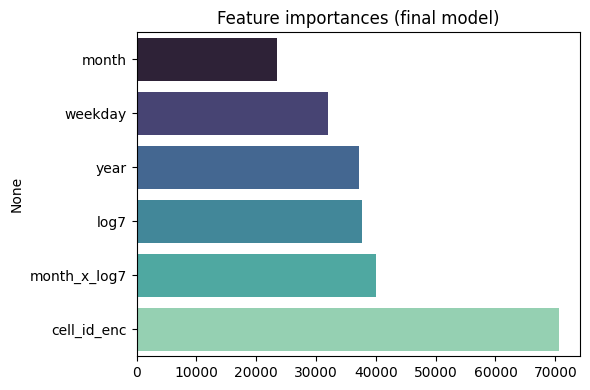

In [ ]:
# Попробуем также логарифмировать новые фичи
df = df_sub.copy()
df['log7']  = np.log1p(df['fires_last_7d'])
df['log30'] = np.log1p(df['fires_last_30d'])
df['month_x_log7']  = df['month'] * df['log7']
df['month_x_log30'] = df['month'] * df['log30']
df['ratio_7_30']    = df['fires_last_7d'] / (df['fires_last_30d'] + 1)

features = ['cell_id_enc', 'year', 'month', 'weekday', 'log7', 'month_x_log7'] # здесь сразу убраны фичи по 30 дням, ибо их важность была либо 0 либо очень близко к 0
X = df[features]
y = df['target']

#оптуна
def objective(trial):
    params = {
        "n_estimators":       trial.suggest_int("n_estimators", 100, 1000),
        "learning_rate":      trial.suggest_float("learning_rate", 0.005, 0.2, log=True),
        "num_leaves":         trial.suggest_int("num_leaves", 16, 256),
        "max_depth":          trial.suggest_int("max_depth", 3, 15),
        "min_data_in_leaf":   trial.suggest_int("min_data_in_leaf", 10, 100),
        "feature_fraction":   trial.suggest_float("feature_fraction", 0.5, 1.0),
        "bagging_fraction":   trial.suggest_float("bagging_fraction", 0.5, 1.0),
        "bagging_freq":       trial.suggest_int("bagging_freq", 1, 10),
        "lambda_l1":          trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2":          trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "objective":          "binary",
        "metric":             "auc",
        "verbosity":          -1,
        "seed":               42,
    }

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    aucs = []
    for train_idx, valid_idx in skf.split(X, y):
        X_tr, X_va = X.iloc[train_idx], X.iloc[valid_idx]
        y_tr, y_va = y.iloc[train_idx], y.iloc[valid_idx]

        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_va, y_va)],
            callbacks=[lgb.early_stopping(stopping_rounds=50)]
        )

        preds = model.predict_proba(X_va)[:, 1]
        aucs.append(roc_auc_score(y_va, preds))

    return float(np.mean(aucs))


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("Best AUC:", study.best_value)
print("Best params:", study.best_params)

best_params = study.best_params.copy()
best_params.update({
    "objective": "binary",
    "metric": "auc",
    "verbosity": -1,
    "seed": 42
})
final_model = lgb.LGBMClassifier(**best_params)
X_trn, X_vld, y_trn, y_vld = train_test_split(X, y, test_size=0.2,
                                              stratify=y, random_state=42)
final_model.fit(X_trn, y_trn)

probs = final_model.predict_proba(X_vld)[:,1]
preds = (probs > 0.5).astype(int)
print(f"\nFinal ROC AUC: {roc_auc_score(y_vld, probs):.4f}")
print(f"Final  F1    : {f1_score(y_vld, preds):.4f}")

imps = pd.Series(final_model.feature_importances_, index=features).sort_values()
plt.figure(figsize=(6,4))
sns.barplot(x=imps.values, y=imps.index, palette="mako")
plt.title("Feature importances (final model)")
plt.tight_layout()
plt.show()

#Best AUC: 0.9164555529553774
# Best params: {
# 'n_estimators': 997, 
# 'learning_rate': 0.030066033309599616, 
# 'num_leaves': 245, 
# 'max_depth': 11, 
# 'min_data_in_leaf': 10, 
# 'feature_fraction': 0.8149802825114707, 
# 'bagging_fraction': 0.8413049951145121, 
# 'bagging_freq': 4, 
# 'lambda_l1': 0.002239413615492012, 
# 'lambda_l2': 0.06067865194148871}

# Final ROC AUC: 0.9207
# Final  F1    : 0.8495


# Итоги улучшения модели

1. Бейзлайн
    + Основные признаки: месяц, день недели, год, код ячейки
    + Обучал LGBM на выборке в 100к(50\50 позитивы негативы)
    + Итоги
        - ROC AUC: 0.880401795
        - F1      : 0.8041515809799662

2. Фиче инжиниринг
* Добавлены пространственно-временные фичи:
    + fires last 7d и filre last 30d - число пожаров в радиусе 5 км за последние 7 и 30 дней (за 30 дней по итогу не дали никакой пользы)
    + Логарифмированы эти фичи log7 log30 и в связке с месяцем month_x_log7
    + Новый набор признаков влияющих на обучение: cell_id_enc, yer, month, weekday, log7, month_x_log7

3. Подбор гиперпараметров через Оптуна на расширенном датасете
    + Итоги
        - ROC AUC = 0.9207 (+4.04  относительно бейзлайна)
        - F1 = 0.8495 (+4.5  относительно бейзлайна)

4. Планы на доработку
    + Добить историю с аугментацией через погодные фичи - т.к. это будет являться (по-моему мнению) одним из ключевых факторов предсказания новых пожаров в конкретных координатах (ниже попытка сделать это5)
    + Поработать с матрицей ошибок, чтобы проверить фолс позитивы\негативы, но возможно только после сбора финального датасета
    + Попробовать ансамблирование через LGBM, catboost и RF через стекинг с LR
    + Обновить оптуну, чтобы оптимизация шла сразу по ROC AUC и F1, а не тольк по AUC как сейчас
    + Перейти к TimeSeriesSplit и GroupKFold, чтобы исключить ближайшие точки от попадания в оба датасета для трейн и валидейт, а также чтобы временной ряд разделялся строго в возрастающем порядке
    + Попробовать калибровку вероятностей

# Попытка аугментации данных о погоде в конкретноее время в конкретных координатах от ERA5 https://cds.climate.copernicus.eu

К сожалению, в услових ограниченного времени, и ограниченных ресурсов, не успел в нескольких итерациях довести этот шаг до конца, ибо датасет погодный за 12 лет за все дни и всего за 1 временной промежуток (12.00 часов дня) весит 2Гб и даже разбив на чанки, просто итерация сбора данных из файла датасета заняла 9 часов и далее упало в ошибку.

Буду дальше пробовать и уменьшать чанки, чтобы быстрее протестировать, но уже не в рамках этой домашки.

In [ ]:


# import xarray as xr
# import pandas as pd
# import numpy as np
# from pathlib import Path
# from tqdm.auto import tqdm  

# df_sub["date"] = df_sub["dt"].dt.date

# DATA_DIR = Path("datasets") / "data"
# ds_i = xr.open_dataset(DATA_DIR / "data_stream-oper_stepType-instant.nc",
#                        chunks={"valid_time": 1})
# ds_a = xr.open_dataset(DATA_DIR / "data_stream-oper_stepType-accum.nc",
#                        chunks={"valid_time": 1})

# hour = ds_i["valid_time"].dt.hour
# ds_i_mid = ds_i.sel(valid_time=hour==12)[["t2m","u10","v10","latitude","longitude","valid_time"]]
# ds_a_mid = ds_a.sel(valid_time=hour==12)[["tp","latitude","longitude","valid_time"]]

# ds_i_mid = ds_i_mid.rename(valid_time="time")
# ds_a_mid = ds_a_mid.rename(valid_time="time")

# ds = xr.merge([ds_i_mid, ds_a_mid])
# ds["windspeed_10m"] = np.sqrt(ds["u10"]**2 + ds["v10"]**2)
# ds = ds.assign(
#     lon_cell = (ds.longitude // 0.5) * 0.5,
#     lat_cell = (ds.latitude  // 0.5) * 0.5,
#     date     = ds["time"].dt.floor("D")
# )

# records = []
# unique_dates = np.unique(ds["date"].values)
# for day in tqdm(unique_dates, desc="Aggregating days"):
#     sub = ds.sel(time=str(day), method="nearest")  
#     if abs((sub.time.dt.floor("D") - np.datetime64(day))) > np.timedelta64(1, "h"):
#         continue
#     df_day = sub.to_dataframe().reset_index()
#     df_agg = df_day.groupby(["date","lon_cell","lat_cell"], as_index=False).agg({
#         "t2m":           "mean",
#         "tp":            "sum",
#         "windspeed_10m": "mean"
#     })
#     records.append(df_agg)

# df_weather = pd.concat(records, ignore_index=True)

# df = df_sub.merge(df_weather, on=["date","lon_cell","lat_cell"], how="left")

# for c in ["t2m","tp","windspeed_10m"]:
#     df[c].fillna(df[c].mean(), inplace=True)

# df = df.sort_values("dt")
# for w in (7,14,30):
#     df[f"t2m_{w}d"] = (
#         df.groupby(["lon_cell","lat_cell"])["t2m"]
#           .rolling(w, min_periods=1).mean()
#           .reset_index(0,drop=True)
#     )
#     df[f"tp_{w}d"] = (
#         df.groupby(["lon_cell","lat_cell"])["tp"]
#           .rolling(w, min_periods=1).sum()
#           .reset_index(0,drop=True)
#     )
#     df[f"wind_{w}d"] = (
#         df.groupby(["lon_cell","lat_cell"])["windspeed_10m"]
#           .rolling(w, min_periods=1).mean()
#           .reset_index(0,drop=True)
#     )

# df.to_csv("data_with_weather_midday.csv", index=False)
# print(" Сохранён data_with_weather_midday.csv")


C:\Users\anatb\AppData\Local\Temp\ipykernel_13308\1411253285.py:12: UserWarning: The specified chunks separate the stored chunks along dimension "valid_time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  ds_i = xr.open_dataset(DATA_DIR / "data_stream-oper_stepType-instant.nc",
C:\Users\anatb\AppData\Local\Temp\ipykernel_13308\1411253285.py:14: UserWarning: The specified chunks separate the stored chunks along dimension "valid_time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  ds_a = xr.open_dataset(DATA_DIR / "data_stream-oper_stepType-accum.nc",
Aggregating days:  76%|███████▌  | 2819/3704 [6:25:28<1:58:27,  8.03s/it]